<a href="https://colab.research.google.com/github/JeonghwaLee-TwinDAD/CarND-Behavioral-Cloning/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving utils.py to utils.py
User uploaded file "utils.py" with length 5248 bytes


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Start building model

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils import INPUT_SHAPE, batch_generator, augument, preprocess

In [87]:
DATA_DIR = './data/'
KEEP_PROB = 0.5
EPOCHS = 100
BATCH_SIZE = 40

## load the driving log (csv format) 

In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/CarND/CarND-Behavioral-Cloning/data.zip'

Streaming output truncated to the last 5000 lines.
  inflating: data/IMG/right_2016_12_01_13_42_28_400.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_400.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_28_502.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_502.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_28_604.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_604.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_28_705.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_705.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_28_806.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_806.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_28_906.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_28_906.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_29_007.jpg  
  inflating: __MACOSX/data/IMG/._right_2016_12_01_13_42_29_007.jpg  
  inflating: data/IMG/right_2016_12_01_13_42_29_109.jpg  
  

In [ ]:
import os
import pandas as pd
import numpy as np

"""
Load training data and split it into training and validation set
"""

data_df = pd.read_csv(os.path.join(DATA_DIR, 'driving_log.csv'))

# Remove the white space 
X = np.array([{item.strip() for item in s} for s in data_df[['center','left','right']].values])  
y = data_df['steering'].values

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
print('Number of Train set : ', len(X_train))
print('Number of Validation set : ', len(X_valid))

Number of Train set :  6428
Number of Validation set :  1608


## Sample images

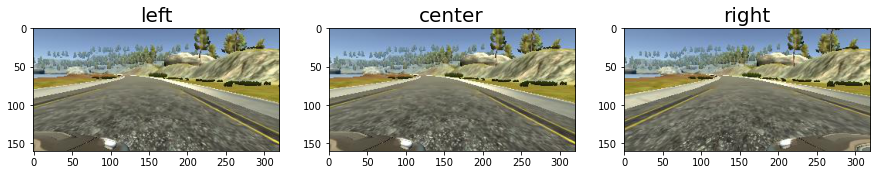

In [34]:
import random

n_samples = 1

X_path = X_train[random.sample(range(0,len(X_train)),n_samples)]

fig, axs = plt.subplots(1,3, figsize=(15,5))

for i in range(n_samples):
  left_img_path, center_img_path, right_img_path = X_path[i]

  left_img_path = os.path.join(DATA_DIR, left_img_path)
  left_img = plt.imread(left_img_path)
  axs[0].imshow(left_img.squeeze())
  axs[0].set_title('left',fontsize=20)

  center_img_path = os.path.join(DATA_DIR, center_img_path)
  center_img = plt.imread(left_img_path)
  axs[1].imshow(center_img.squeeze())
  axs[1].set_title('center',fontsize=20)

  right_img_path = os.path.join(DATA_DIR, right_img_path)
  right_img = plt.imread(right_img_path)
  axs[2].imshow(right_img.squeeze())
  axs[2].set_title('right',fontsize=20)

plt.show()


## Preprocessing images

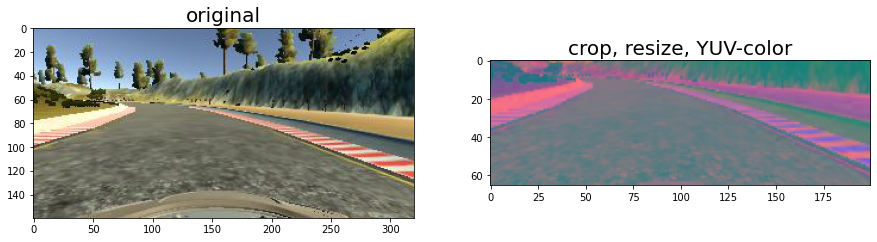

In [85]:
X_sample_path = X_train[random.sample(range(0,len(X_train)),1)]
_,img_path,_=X_sample_path[0]

sample_path = DATA_DIR + img_path

sample_image = plt.imread(sample_path.strip())
process_image = preprocess(sample_image)

fig, axs = plt.subplots(1,2, figsize=(15, 5))

axs[0].imshow(sample_image.squeeze())
axs[0].set_title('original',fontsize=20)

axs[1].imshow(process_image.squeeze())
axs[1].set_title('crop, resize, YUV-color',fontsize=20)

plt.show()

### Build the modified NVIDIA model 

In [88]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Lambda, Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Cropping2D

model = Sequential()
model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
model.add(Conv2D(24,(5, 5), activation='elu', strides=(2, 2), padding='valid'))
model.add(Conv2D(36,(5, 5), activation='elu', strides=(2, 2), padding='valid'))
model.add(Conv2D(48,(5, 5), activation='elu', strides=(2, 2), padding='valid'))
model.add(Conv2D(64,(3, 3), activation='elu'))
model.add(Conv2D(64,(3, 3), activation='elu'))
model.add(Dropout(KEEP_PROB))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 18, 64)        

### Run training

In [89]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('model-{epoch:03d}.h5',
                             monitor='val_loss',
                             verbose=0,
                             save_best_only='true',
                             mode='auto')

model.compile(loss='mse', optimizer='adam')
     
train_generator = batch_generator(DATA_DIR, X_train, y_train, BATCH_SIZE, True)
valid_generator = batch_generator(DATA_DIR, X_valid, y_valid, BATCH_SIZE, False)

history_object = model.fit(train_generator, 
                  steps_per_epoch=len(X_train)//BATCH_SIZE,
                  validation_data=valid_generator, 
                  validation_steps=len(X_valid)//BATCH_SIZE,
                  epochs = EPOCHS,
                  callbacks=[checkpoint],
                  verbose=1,
                  shuffle=1)

Epoch 1/100
160/160 [==============================] - 15s 92ms/step - loss: 0.0439 - val_loss: 0.0129
Epoch 2/100
160/160 [==============================] - 15s 92ms/step - loss: 0.0326 - val_loss: 0.0138
Epoch 3/100
160/160 [==============================] - 15s 92ms/step - loss: 0.0317 - val_loss: 0.0130
Epoch 4/100
160/160 [==============================] - 15s 92ms/step - loss: 0.0314 - val_loss: 0.0117
Epoch 5/100
160/160 [==============================] - 15s 93ms/step - loss: 0.0313 - val_loss: 0.0108
Epoch 6/100
160/160 [==============================] - 15s 91ms/step - loss: 0.0293 - val_loss: 0.0128
Epoch 7/100
160/160 [==============================] - 15s 91ms/step - loss: 0.0301 - val_loss: 0.0115
Epoch 8/100
160/160 [==============================] - 15s 93ms/step - loss: 0.0303 - val_loss: 0.0109
Epoch 9/100
160/160 [==============================] - 15s 92ms/step - loss: 0.0285 - val_loss: 0.0115
Epoch 10/100
160/160 [==============================] - 15s 91ms/step - l

## plot the training and validation loss for each epoch

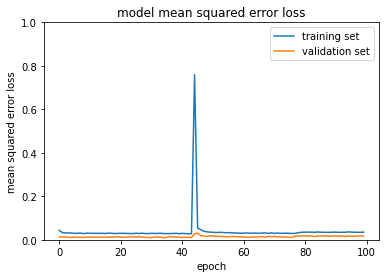

In [90]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.ylim(0, 1)
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()